In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os

base_dir = os.getcwd()  
#print("当前工作目录:", base_dir)
parent_dir = os.path.dirname(base_dir)    
csv_path = {0: os.path.join(parent_dir, "RWD_20250422/D1T4", "observation_data_case5.csv"),
            1: os.path.join(parent_dir, "for_real", "Case1_Urban_10Hz.csv"),
            2: os.path.join(parent_dir, "for_real", "Case1_Suburban_10Hz.csv"),
            3: os.path.join(parent_dir, "for_real", "Case2_Urban_10Hz.csv"),
            4: os.path.join(parent_dir, "for_real", "Case2_Suburban_10Hz.csv"),
            5: os.path.join(parent_dir, "for_real", "Case3_Urban_10Hz.csv"),
            6: os.path.join(parent_dir, "for_real", "Case3_Suburban_10Hz.csv"),
            7: os.path.join(parent_dir, "for_real", "Case4_Urban_10Hz.csv"),
            8: os.path.join(parent_dir, "for_real", "Case4_Suburban_10Hz.csv"),
            }


data = {}
for key in csv_path.keys():
    # data[key] = pd.read_csv(csv_path[key])
    # print('\n Case', key, ': Length of data =', len(data[key]['gps_time']), ', Duration =', data[key]['gps_time'].iloc[-1] - data[key]['gps_time'].iloc[0], 's, columns =', data[key].columns.tolist())
    # print(data[key].head())
    
    df = pd.read_csv(csv_path[key])
     
    length = len(df)
    duration = df['gps_time'].iloc[-1] - df['gps_time'].iloc[0] if length > 1 else 0
    columns = df.columns.tolist()
    # Type masks
    pl_mask = df['satellite_id'].str.startswith("P")
    pl_total = pl_mask.sum()
    gps_mask = df['satellite_id'].str.startswith("G")
    gps_total = gps_mask.sum()

    # Multipath labels
    if key == 0:
        total_los = total_nlos = pl_los = pl_nlos = gps_los = gps_nlos = 0
    else:
        total_los  = (df['multipath'] == 0).sum()
        total_nlos = (df['multipath'] == 1).sum()
        
        pl_los  = ((pl_mask) & (df['multipath'] == 0)).sum()
        pl_nlos = ((pl_mask) & (df['multipath'] == 1)).sum()

        gps_los  = ((gps_mask) & (df['multipath'] == 0)).sum()
        gps_nlos = ((gps_mask) & (df['multipath'] == 1)).sum()

    # Print formatted summary
    print(f"\n📦 Case {key}: {os.path.basename(csv_path[key])}")
    print(f"  ▶ Length     : {length} rows")
    print(f"  ▶ Duration   : {duration:.2f} s")
    print(f"  ▶ Columns    : {len(columns)} → {columns}")
    print(f"  ▶ PL         : {pl_total} (LOS: {pl_los}, NLOS: {pl_nlos}) (LOS %: {pl_los/pl_total*100:.1f}%, NLOS %: {pl_nlos/pl_total*100:.1f}%)")
    print(f"  ▶ GPS        : {gps_total} (LOS: {gps_los}, NLOS: {gps_nlos}) (LOS %: {gps_los/gps_total*100:.1f}%, NLOS %: {gps_nlos/gps_total*100:.1f}%)")
    if key != 0:
        print(f"  ▶ Total SIG  : LOS: {total_los}, NLOS: {total_nlos} (LOS %: {total_los/(total_los+total_nlos)*100:.1f}%, NLOS %: {total_nlos/(total_los+total_nlos)*100:.1f}%)")





📦 Case 0: observation_data_case5.csv
  ▶ Length     : 12614 rows
  ▶ Duration   : 52.50 s
  ▶ Columns    : 13 → ['gps_time', 'satellite_id', 'sv_id', 'pseudorange', 'doppler_shift', 'cn0', 'azimuth', 'elevation', 'pseudorange_residual', 'pseudorange_corrected_cb', 'sat_px', 'sat_py', 'sat_pz']
  ▶ PL         : 1394 (LOS: 0, NLOS: 0) (LOS %: 0.0%, NLOS %: 0.0%)
  ▶ GPS        : 5788 (LOS: 0, NLOS: 0) (LOS %: 0.0%, NLOS %: 0.0%)

📦 Case 1: Case1_Urban_10Hz.csv
  ▶ Length     : 91719 rows
  ▶ Duration   : 599.00 s
  ▶ Columns    : 12 → ['gps_time', 'satellite_id', 'sv_id', 'pseudorange', 'doppler_shift', 'cn0', 'rec_pow', 'azimuth', 'elevation', 'pseudorange_residual', 'pseudorange_corrected_cb', 'multipath']
  ▶ PL         : 35946 (LOS: 29912, NLOS: 6034) (LOS %: 83.2%, NLOS %: 16.8%)
  ▶ GPS        : 55773 (LOS: 10853, NLOS: 44920) (LOS %: 19.5%, NLOS %: 80.5%)
  ▶ Total SIG  : LOS: 40765, NLOS: 50954 (LOS %: 44.4%, NLOS %: 55.6%)

📦 Case 2: Case1_Suburban_10Hz.csv
  ▶ Length     : 917

In [2]:
# Define cases
real_case = 0
# training_data = [1,2,3,4,5,6]
# testing_data = [7,8]
training_data = [2,3]
testing_data = [4]


# Load real case
df_real = pd.read_csv(csv_path[real_case])

# Load training cases into one DataFrame
df_train = pd.concat(
    [pd.read_csv(csv_path[k]).assign(case_id=k) for k in training_data],
    ignore_index=True
)

# Load testing cases into one DataFrame
df_test = pd.concat(
    [pd.read_csv(csv_path[k]).assign(case_id=k) for k in testing_data],
    ignore_index=True
)

# Classify satellite types in all DataFrames (PL=1, GPS=0, OTHER=-1)
for df in [df_real, df_train, df_test]:
    df['satellite_id'] = df['satellite_id'].astype(str)
    df['sat_type'] = np.where(
        df['satellite_id'].str.contains("^P", na=False), 1, # ^ means “start of string”.
        np.where(df['satellite_id'].str.contains("^G", na=False), 0, -1)
    )

print("Any real data OTHER than PL/GPS?", (df_real['sat_type'] == -1).any())
print("Any train data OTHER than PL/GPS?", (df_train['sat_type'] == -1).any())
print("Any test data OTHER than PL/GPS?", (df_test['sat_type'] == -1).any())

Any real data OTHER than PL/GPS? True
Any train data OTHER than PL/GPS? False
Any test data OTHER than PL/GPS? False


In [3]:
for col in ["doppler_shift", "elevation", "pseudorange_residual", "pseudorange_corrected_cb", "cn0"]:
    print(f"\n📊 Feature: {col}")
    for sat_type in [0, 1]:  # 0 = GPS, 1 = PL
        real_mask = df_real["sat_type"] == sat_type
        train_mask = df_train["sat_type"] == sat_type

        real_mean = df_real.loc[real_mask, col].mean()
        train_mean = df_train.loc[train_mask, col].mean()
        diff = real_mean - train_mean

        print(f"  sat_type {sat_type}: Real mean = {real_mean:.4f}, Train mean = {train_mean:.4f}, Diff = {diff:.4f}")



📊 Feature: doppler_shift
  sat_type 0: Real mean = -191.2868, Train mean = -27.4664, Diff = -163.8204
  sat_type 1: Real mean = 52.1876, Train mean = -0.0011, Diff = 52.1887

📊 Feature: elevation
  sat_type 0: Real mean = 43.2567, Train mean = 35.3412, Diff = 7.9155
  sat_type 1: Real mean = 4.4673, Train mean = 15.5046, Diff = -11.0373

📊 Feature: pseudorange_residual
  sat_type 0: Real mean = -0.3730, Train mean = -0.3427, Diff = -0.0304
  sat_type 1: Real mean = 1.2762, Train mean = -0.3049, Diff = 1.5811

📊 Feature: pseudorange_corrected_cb
  sat_type 0: Real mean = 22186348.1537, Train mean = 22612315.6011, Diff = -425967.4474
  sat_type 1: Real mean = 26.7248, Train mean = 22.5770, Diff = 4.1478

📊 Feature: cn0
  sat_type 0: Real mean = 43.6147, Train mean = 36.2806, Diff = 7.3341
  sat_type 1: Real mean = 47.7305, Train mean = 167.2583, Diff = -119.5279


In [4]:

# --- Compute real-world medians for PL and GPS ---
real_pl_med  = df_real.loc[df_real['sat_type'] == 1, 'cn0'].median()
real_gps_med = df_real.loc[df_real['sat_type'] == 0, 'cn0'].median()

# --- Align cn0 in training data ---
train_pl_med  = df_train.loc[df_train['sat_type'] == 1, 'cn0'].median()
train_gps_med = df_train.loc[df_train['sat_type'] == 0, 'cn0'].median()

diff_pl  = real_pl_med  - train_pl_med
diff_gps = real_gps_med - train_gps_med

df_train['cn0_new'] = df_train['cn0']
df_test['cn0_new'] = df_test['cn0']
df_train.loc[df_train['sat_type'] == 1, 'cn0_new'] += diff_pl
df_train.loc[df_train['sat_type'] == 0, 'cn0_new'] += diff_gps
df_test.loc[df_test['sat_type'] == 1, 'cn0_new'] += diff_pl
df_test.loc[df_test['sat_type'] == 0, 'cn0_new'] += diff_gps

print(f"Real PL median: {real_pl_med}, Train PL median: {train_pl_med}, Diff: {diff_pl}")
print(f"Real GPS median: {real_gps_med}, Train GPS median: {train_gps_med}, Diff: {diff_gps}")
print(f"After adjustment, New Train PL median: {df_train.loc[df_train['sat_type'] == 1, 'cn0_new'].median()}")
print(f"After adjustment, New Train GPS median: {df_train.loc[df_train['sat_type'] == 0, 'cn0_new'].median()}")



Real PL median: 48.8056396296138, Train PL median: 170.05416582270487, Diff: -121.24852619309107
Real GPS median: 45.4344222328504, Train GPS median: 42.0615650724157, Diff: 3.372857160434698
After adjustment, New Train PL median: 48.80563962961381
After adjustment, New Train GPS median: 45.434422232850395


In [5]:
from sklearn.utils import resample

# Split by sat_type and multipath
gps_los  = df_train[(df_train["sat_type"] == 0) & (df_train["multipath"] == 0)]
gps_nlos = df_train[(df_train["sat_type"] == 0) & (df_train["multipath"] == 1)]
pl_los   = df_train[(df_train["sat_type"] == 1) & (df_train["multipath"] == 0)]
pl_nlos  = df_train[(df_train["sat_type"] == 1) & (df_train["multipath"] == 1)]

# Determine smallest group size for each sat_type
min_gps = min(len(gps_los), len(gps_nlos))
min_pl  = min(len(pl_los), len(pl_nlos))

# Resample each group
gps_los_bal  = resample(gps_los,  n_samples=min_gps, replace=False, random_state=42)
gps_nlos_bal = resample(gps_nlos, n_samples=min_gps, replace=False, random_state=42)
pl_los_bal   = resample(pl_los,   n_samples=min_pl,  replace=False, random_state=42)
pl_nlos_bal  = resample(pl_nlos,  n_samples=min_pl,  replace=False, random_state=42)

# Combine and shuffle
df_train_bal = pd.concat(
    [gps_los_bal, gps_nlos_bal, pl_los_bal, pl_nlos_bal],
    ignore_index=True
).sample(frac=1, random_state=42)

# Print summary
print("✅ Balanced training set created:")
print("  - GPS LOS :", len(gps_los_bal))
print("  - GPS NLOS:", len(gps_nlos_bal))
print("  - PL LOS  :", len(pl_los_bal))
print("  - PL NLOS :", len(pl_nlos_bal))
print("  - Total   :", len(df_train_bal))


✅ Balanced training set created:
  - GPS LOS : 28517
  - GPS NLOS: 28517
  - PL LOS  : 13450
  - PL NLOS : 13450
  - Total   : 83934


[LibLinear]=== Balanced Linear SVM Report ===
              precision    recall  f1-score   support

           0       0.68      0.97      0.80     35227
           1       0.97      0.63      0.76     44667

    accuracy                           0.78     79894
   macro avg       0.82      0.80      0.78     79894
weighted avg       0.84      0.78      0.78     79894



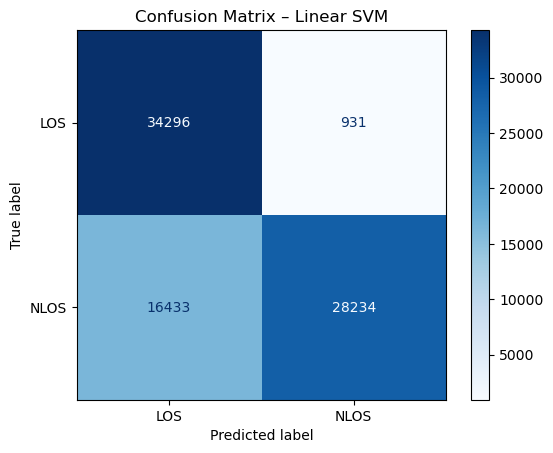

In [6]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Features and target
features = ["cn0_new", "elevation", "pseudorange_residual", "sat_type"]
target = "multipath"

# Drop NA values
df_train_bal = df_train_bal.dropna(subset=features + [target])
df_test = df_test.dropna(subset=features + [target])

# Define X, y
X_train = df_train_bal[features]
y_train = df_train_bal[target]
X_test = df_test[features]
y_test = df_test[target]

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear SVM
svm_all = LinearSVC(C=1.0, max_iter=10000, verbose=1)  # verbose=1 prints training progress
svm_all.fit(X_train_scaled, y_train)
y_pred = svm_all.predict(X_test_scaled)

# Classification report
print("=== Balanced Linear SVM Report ===")
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["LOS", "NLOS"], cmap="Blues"
)
plt.title("Confusion Matrix – Linear SVM")
plt.show()


In [7]:

if "cn0_new" not in df_real.columns and "cn0" in df_real.columns:
    df_real["cn0_new"] = df_real["cn0"]

# print(df_real[df_real[features].isna().any(axis=1)].head())

# Remove missing values (optional but recommended)
df_real_filtered = df_real.dropna(subset=features).copy()

# Standardize using the same scaler used for training
X_real = df_real_filtered[features]
X_real_scaled = scaler.transform(X_real)

# Predict using the trained combined SVM model
y_real_pred = svm_all.predict(X_real_scaled)
print(f"Predicted {np.sum(y_real_pred==0)} LOS and {np.sum(y_real_pred==1)} NLOS in real data.")

# Add predictions to the DataFrame
df_real_filtered["predicted_multipath"] = y_real_pred  # 0 = LOS, 1 = NLOS

for sat_label, sat_name in zip([0, 1], ["GPS", "PL"]):
    df_sat = df_real_filtered[df_real_filtered["sat_type"] == sat_label]
    los_count = (df_sat["predicted_multipath"] == 0).sum()
    nlos_count = (df_sat["predicted_multipath"] == 1).sum()
    total = len(df_sat)
    
    los_percent = 100 * los_count / total if total > 0 else 0
    nlos_percent = 100 * nlos_count / total if total > 0 else 0

    print(f"\n🔎 {sat_name} Signals:")
    print(f"  ▶ Total           : {total}")
    print(f"  ▶ Predicted LOS   : {los_count} ({los_percent:.1f}%)")
    print(f"  ▶ Predicted NLOS  : {nlos_count} ({nlos_percent:.1f}%)")



Predicted 9187 LOS and 2056 NLOS in real data.

🔎 GPS Signals:
  ▶ Total           : 4982
  ▶ Predicted LOS   : 3208 (64.4%)
  ▶ Predicted NLOS  : 1774 (35.6%)

🔎 PL Signals:
  ▶ Total           : 1394
  ▶ Predicted LOS   : 1121 (80.4%)
  ▶ Predicted NLOS  : 273 (19.6%)


In [8]:
# # Save to CSV
# file_name = "real_with_predicted_multipath_svm_bal.csv"
# df_real_filtered.to_csv(file_name, index=False)
# print("✅ Saved: ", file_name)

In [9]:
# from sklearn.svm import LinearSVC, SVC
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt


# # Define features and target
# features = ["cn0_new", "elevation", "pseudorange_residual", "sat_type"]
# target = "multipath"
# group_col = "case_id"

# # Split data
# X_train = df_train[features]
# y_train = df_train[target]
# X_test = df_test[features]
# y_test = df_test[target]

# # Standardize
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # ✅ CASE 1: Combined model using LinearSVC (interpretable)
# svm_all = LinearSVC(C=1.0, max_iter=10000, verbose=1) #, class_weight='balanced'
# # svm_all = SVC(kernel='rbf', C=1.0, gamma='scale', verbose=True)

# svm_all.fit(X_train_scaled, y_train)
# y_pred_all = svm_all.predict(X_test_scaled)
# report_all = classification_report(y_test, y_pred_all, output_dict=False)

# # Display results
# print("\n=== Combined Model Report (GPS + PL) — Linear SVM ===")
# print(report_all)

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_all)
# labels = ["LOS (0)", "NLOS (1)"]
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap="Blues", values_format="d")
# plt.title("Confusion Matrix – Linear SVM Model (GPS + PL)")
# plt.show()

# # ✅ Feature Importance Plot
# coef = svm_all.coef_[0]
# plt.figure(figsize=(8, 5))
# plt.barh(features, coef)
# plt.xlabel("Coefficient Weight")
# plt.title("Feature Importance – Linear SVM")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [10]:

# if "cn0_new" not in df_real.columns and "cn0" in df_real.columns:
#     df_real["cn0_new"] = df_real["cn0"]

# # print(df_real[df_real[features].isna().any(axis=1)].head())

# # Remove missing values (optional but recommended)
# df_real_filtered = df_real.dropna(subset=features).copy()

# # Standardize using the same scaler used for training
# X_real = df_real_filtered[features]
# X_real_scaled = scaler.transform(X_real)

# # Predict using the trained combined SVM model
# y_real_pred = svm_all.predict(X_real_scaled)
# print(f"Predicted {np.sum(y_real_pred==0)} LOS and {np.sum(y_real_pred==1)} NLOS in real data.")

# # Add predictions to the DataFrame
# df_real_filtered["predicted_multipath"] = y_real_pred  # 0 = LOS, 1 = NLOS

# for sat_label, sat_name in zip([0, 1], ["GPS", "PL"]):
#     df_sat = df_real_filtered[df_real_filtered["sat_type"] == sat_label]
#     los_count = (df_sat["predicted_multipath"] == 0).sum()
#     nlos_count = (df_sat["predicted_multipath"] == 1).sum()
#     total = len(df_sat)
    
#     los_percent = 100 * los_count / total if total > 0 else 0
#     nlos_percent = 100 * nlos_count / total if total > 0 else 0

#     print(f"\n🔎 {sat_name} Signals:")
#     print(f"  ▶ Total           : {total}")
#     print(f"  ▶ Predicted LOS   : {los_count} ({los_percent:.1f}%)")
#     print(f"  ▶ Predicted NLOS  : {nlos_count} ({nlos_percent:.1f}%)")



In [11]:
# # Save to CSV
# file_name = "real_with_predicted_multipath_svm_bal.csv"
# df_real_filtered.to_csv(file_name, index=False)
# print("✅ Saved: ", file_name)

In [12]:
# # from sklearn.model_selection import GroupKFold
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Define features and target
# # features = ["doppler_shift", "cn0_new", "elevation", "pseudorange_residual", "pseudorange_corrected_cb", "sat_type"]
# features = ["cn0_new", "elevation", "pseudorange_residual", "sat_type"]
# target = "multipath"
# group_col = "case_id"

# # Split data
# X_train = df_train[features]
# y_train = df_train[target]

# X_test = df_test[features]
# y_test = df_test[target]

# # Standardize
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # CASE 1: Combined model
# svm_all = SVC(kernel='rbf', C=1.0, gamma='scale', verbose=True)
# svm_all.fit(X_train_scaled, y_train)
# y_pred_all = svm_all.predict(X_test_scaled)
# report_all = classification_report(y_test, y_pred_all, output_dict=False)


# # # Display results
# print("=== Combined Model Report (GPS + PL) ===")
# print(report_all)

# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_pred_all)

# # Optional: display labels for binary classification (0 = LOS, 1 = NLOS for example)
# labels = ["LOS (0)", "NLOS (1)"]

# # Display the confusion matrix as a heatmap
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap="Blues", values_format="d")
# plt.title("Confusion Matrix – Combined SVM Model (GPS + PL)")
# plt.show()


# Others


In [13]:
from sklearn.svm import SVC
import numpy as np

# Ensure cn0_new exists
if "cn0_new" not in df_real.columns and "cn0" in df_real.columns:
    df_real["cn0_new"] = df_real["cn0"]

# Remove missing values (optional but recommended)
df_real_filtered = df_real.dropna(subset=features).copy()

# Standardize using the same scaler used for training
X_real = df_real_filtered[features]
X_real_scaled = scaler.transform(X_real)

# Predict probabilities with the original trained model
svm_all_with_proba = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_all_with_proba.fit(X_train_scaled, y_train)


SVC(probability=True)

In [14]:

probas = svm_all_with_proba.predict_proba(X_real_scaled)
y_real_pred = np.argmax(probas, axis=1)
conf = np.max(probas, axis=1)

for t in [0.7, 0.8, 0.85, 0.9, 0.95]:
    count = (conf >= t).sum()
    print(f"Threshold {t}: {count} confident predictions")

# Set threshold for confident pseudo-labels
conf_thresh = 0.85
mask = conf >= conf_thresh

X_pseudo = X_real_scaled[mask]
y_pseudo = y_real_pred[mask]

print(f"✅ Pseudo-labeled real samples: {len(X_pseudo)}")
print(f"   └ LOS (0): {(y_pseudo==0).sum()}, NLOS (1): {(y_pseudo==1).sum()}")

# Combine training + confident real data
X_finetune = np.vstack([X_train_scaled, X_pseudo])
y_finetune = np.concatenate([y_train, y_pseudo])

# Retrain/fine-tune the model
# svm_finetuned = SVC(kernel='rbf', C=1.0, gamma='scale')
# svm_finetuned.fit(X_finetune, y_finetune)
svm_all_with_proba.fit(X_finetune, y_finetune)

# Predict on all real data again (after fine-tuning)
# y_real_pred_finetuned = svm_finetuned.predict(X_real_scaled)
y_real_pred_finetuned = svm_all_with_proba.predict(X_real_scaled)
df_real_filtered["predicted_multipath"] = y_real_pred_finetuned  # 0 = LOS, 1 = NLOS

# Show overall prediction stats
print(f"\n📊 Final Prediction on Real Data:")
print(f"   ▶ Predicted LOS  : {(y_real_pred_finetuned==0).sum()}")
print(f"   ▶ Predicted NLOS : {(y_real_pred_finetuned==1).sum()}")

# Grouped by GPS/PL
for sat_label, sat_name in zip([0, 1], ["GPS", "PL"]):
    df_sat = df_real_filtered[df_real_filtered["sat_type"] == sat_label]
    los_count = (df_sat["predicted_multipath"] == 0).sum()
    nlos_count = (df_sat["predicted_multipath"] == 1).sum()
    total = len(df_sat)

    los_percent = 100 * los_count / total if total > 0 else 0
    nlos_percent = 100 * nlos_count / total if total > 0 else 0

    print(f"\n🔎 {sat_name} Signals:")
    print(f"  ▶ Total           : {total}")
    print(f"  ▶ Predicted LOS   : {los_count} ({los_percent:.1f}%)")
    print(f"  ▶ Predicted NLOS  : {nlos_count} ({nlos_percent:.1f}%)")


Threshold 0.7: 10593 confident predictions
Threshold 0.8: 10172 confident predictions
Threshold 0.85: 9658 confident predictions
Threshold 0.9: 8405 confident predictions
Threshold 0.95: 7995 confident predictions
✅ Pseudo-labeled real samples: 9658
   └ LOS (0): 2275, NLOS (1): 7383

📊 Final Prediction on Real Data:
   ▶ Predicted LOS  : 3542
   ▶ Predicted NLOS : 7701

🔎 GPS Signals:
  ▶ Total           : 4982
  ▶ Predicted LOS   : 2478 (49.7%)
  ▶ Predicted NLOS  : 2504 (50.3%)

🔎 PL Signals:
  ▶ Total           : 1394
  ▶ Predicted LOS   : 1064 (76.3%)
  ▶ Predicted NLOS  : 330 (23.7%)


In [15]:
# # Save to CSV
# df_real_filtered.to_csv("real_with_predicted_multipath.csv", index=False)
# print("✅ Saved: df_real_with_predicted_multipath.csv")

[LibSVM]
=== GPS-only Model Report ===
              precision    recall  f1-score   support

           0       0.80      0.46      0.58     15249
           1       0.82      0.96      0.89     40523

    accuracy                           0.82     55772
   macro avg       0.81      0.71      0.73     55772
weighted avg       0.82      0.82      0.80     55772



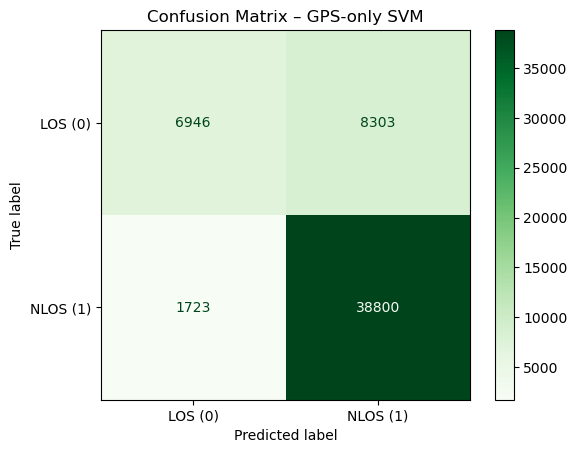

[LibSVM]
=== PL-only Model Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19978
           1       1.00      1.00      1.00      4144

    accuracy                           1.00     24122
   macro avg       1.00      1.00      1.00     24122
weighted avg       1.00      1.00      1.00     24122



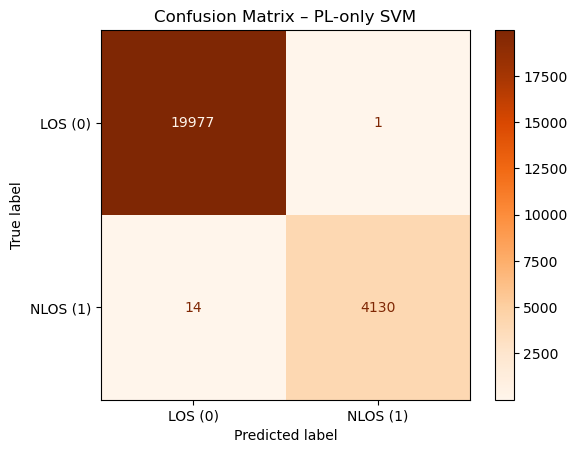

In [16]:
# CASE 2: Separate GPS and PL models
gps_mask_train = df_train['sat_type'] == 0
gps_mask_test  = df_test['sat_type'] == 0
pl_mask_train  = df_train['sat_type'] == 1
pl_mask_test   = df_test['sat_type'] == 1

X_train_gps = df_train.loc[gps_mask_train, features[:-1]] # Exclude 'sat_type'
y_train_gps = df_train.loc[gps_mask_train, target]
X_test_gps  = df_test.loc[gps_mask_test, features[:-1]]
y_test_gps  = df_test.loc[gps_mask_test, target]

X_train_pl = df_train.loc[pl_mask_train, features[:-1]]
y_train_pl = df_train.loc[pl_mask_train, target]
X_test_pl  = df_test.loc[pl_mask_test, features[:-1]]
y_test_pl  = df_test.loc[pl_mask_test, target]

# Scale separately
scaler_gps = StandardScaler()
X_train_gps_scaled = scaler_gps.fit_transform(X_train_gps)
X_test_gps_scaled = scaler_gps.transform(X_test_gps)

scaler_pl = StandardScaler()
X_train_pl_scaled = scaler_pl.fit_transform(X_train_pl)
X_test_pl_scaled = scaler_pl.transform(X_test_pl)

# Train and evaluate
svm_gps = SVC(kernel='rbf', C=1.0, gamma='scale', verbose=True) #, class_weight='balanced'
svm_gps.fit(X_train_gps_scaled, y_train_gps)
y_pred_gps = svm_gps.predict(X_test_gps_scaled)
report_gps = classification_report(y_test_gps, y_pred_gps, output_dict=False)
# --- GPS-only Confusion Matrix ---
print("\n=== GPS-only Model Report ===")
print(report_gps)
cm_gps = confusion_matrix(y_test_gps, y_pred_gps)
disp_gps = ConfusionMatrixDisplay(confusion_matrix=cm_gps, display_labels=["LOS (0)", "NLOS (1)"])
disp_gps.plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix – GPS-only SVM")
plt.show()

svm_pl = SVC(kernel='rbf', C=1.0, gamma='scale', verbose=True)
svm_pl.fit(X_train_pl_scaled, y_train_pl)
y_pred_pl = svm_pl.predict(X_test_pl_scaled)
report_pl = classification_report(y_test_pl, y_pred_pl, output_dict=False)
# --- PL-only Confusion Matrix ---
print("\n=== PL-only Model Report ===")
print(report_pl)
cm_pl = confusion_matrix(y_test_pl, y_pred_pl)
disp_pl = ConfusionMatrixDisplay(confusion_matrix=cm_pl, display_labels=["LOS (0)", "NLOS (1)"])
disp_pl.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix – PL-only SVM")
plt.show()


